# Reference labels and splits - one tile

https://land.copernicus.eu/pan-european/corine-land-cover

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import geopandas as gpd
import pandas as pd

from src import configs

## Load data

In [2]:
prjconf = configs.ProjectConfigParser()
area_threshold = 500000
path_clc_t32unu_subset = prjconf.get_path("Interim", "rootdir") / "clc" / f"clc2018_clc2018_v2018_20b2_raster100m_32UNU_epsg32623_area{area_threshold}.shp"
gdf = gpd.read_file(path_clc_t32unu_subset)

clc_legend = prjconf.get_clc_legend()
clc_legend

,l1_name,l2_name,l3_name,grid_code,rgb,l1_id,l2_id,l3_id
0,ARTIFICIAL SURFACES,Urban fabric,Continuous urban fabric,1,230-000-077,1,11,111
1,ARTIFICIAL SURFACES,Urban fabric,Discontinuous urban fabric,2,255-000-000,1,11,112
2,ARTIFICIAL SURFACES,"Industrial, commercial and transport units",Industrial or commercial units,3,204-077-242,1,12,121
3,ARTIFICIAL SURFACES,"Industrial, commercial and transport units",Road and rail networks and associated land,4,204-000-000,1,12,122
4,ARTIFICIAL SURFACES,"Industrial, commercial and transport units",Port areas,5,230-204-204,1,12,123
5,ARTIFICIAL SURFACES,"Industrial, commercial and transport units",Airports,6,230-204-230,1,12,124
6,ARTIFICIAL SURFACES,"Mine, dump and construction sites",Mineral extraction sites,7,166-000-204,1,13,131
7,ARTIFICIAL SURFACES,"Mine, dump and construction sites",Dump sites,8,166-077-000,1,13,132
8,ARTIFICIAL SURFACES,"Mine, dump and construction sites",Construction sites,9,255-077-255,1,13,133
9,ARTIFICIAL SURFACES,"Artificial, non-agricultural vegetated areas",Green urban areas,10,255-166-255,1,14,141


## Join reference data and legend info

,pid,l3_id,l2_id,l2_name
0,1,311,31,Forests
1,2,313,31,Forests
2,3,311,31,Forests
3,4,311,31,Forests
4,5,312,31,Forests


Inland wetlands                                       33
Artificial, non-agricultural vegetated areas          80
Mine, dump and construction sites                    107
Heterogeneous agricultural areas                     108
Inland waters                                        111
Industrial, commercial and transport units           260
Permanent crops                                      403
Scrub and/or herbaceous vegetation\nassociations     412
Urban fabric                                        1083
Arable land                                         1704
Pastures                                            3531
Forests                                             3945
Name: l2_name, dtype: int64


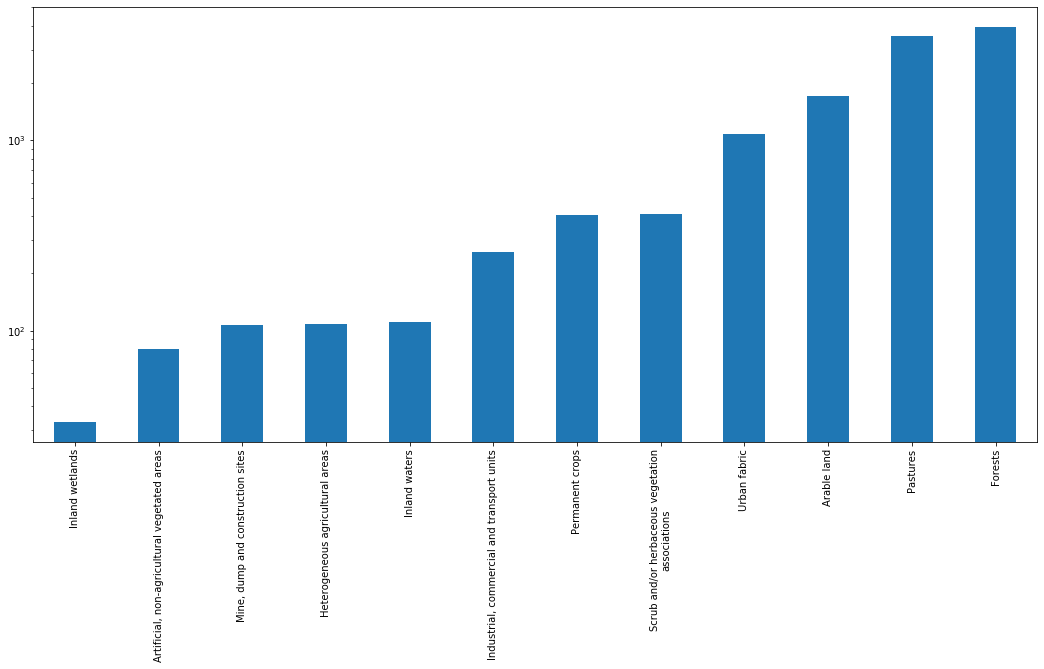

In [3]:
classes = gdf[["PID", "DN"]]
classes.columns = ["pid", "l3_id"]
classes = classes.merge(clc_legend[["l3_id", "l2_id", "l2_name"]], on="l3_id", how="left")
display(classes.head())
print(classes["l2_name"].value_counts(ascending=True))
classes["l2_name"].value_counts(ascending=True).plot.bar(logy=True, figsize=(18, 8))

## Simulate splits

We want an outer cross-validation split for performance estimation and an inner cross-validation split for model selection.



In [4]:
from sklearn.model_selection import StratifiedKFold

# make sure that indices are from 0 to #rows that assignement with .loc below is correct
classes = classes.reset_index(drop=True)
classes["outer_cv_test"] = 255
classes["outer_cv_test"] = classes["outer_cv_test"].astype("uint8")
classes["inner_cv_test"] = 255
classes["inner_cv_test"] = classes["inner_cv_test"].astype("uint8")

In [5]:
n_splits_outer = 3
n_splits_inner = 5

skf = StratifiedKFold(n_splits=n_splits_outer, random_state=123)

counts_split_outer = []
counts_split_inner = []

for k, (train, test) in enumerate(skf.split(classes[["pid"]], classes["l2_id"])):
    print("*" * 80)
    print(f"k - outer = {k}")
    classes.loc[test, "outer_cv_test"] = k
    
    df = pd.concat([classes.loc[train, "l2_name"].value_counts(),
                    classes.loc[test, "l2_name"].value_counts()], axis=1, sort=False)
    df.columns = ["train", "test"]
    df["k"] = k
    
    display(df)
    counts_split_outer.append(df)
    
    # # TODO: add inner split indices
    # col_inner_k = f"inner_outer_k{k}"
    # classes[col_inner_k] = 255
    # classes[col_inner_k] = classes[col_inner_k].astype("uint8")
    
    
    

********************************************************************************
k - outer = 0


,train,test,k
Forests,2630,1315,0
Pastures,2354,1177,0
Arable land,1136,568,0
Urban fabric,722,361,0
Scrub and/or herbaceous vegetation\nassociations,274,138,0
Permanent crops,268,135,0
"Industrial, commercial and transport units",173,87,0
Inland waters,74,37,0
Heterogeneous agricultural areas,72,36,0
"Mine, dump and construction sites",71,36,0


********************************************************************************
k - outer = 1


,train,test,k
Forests,2630,1315,1
Pastures,2354,1177,1
Arable land,1136,568,1
Urban fabric,722,361,1
Scrub and/or herbaceous vegetation\nassociations,275,137,1
Permanent crops,269,134,1
"Industrial, commercial and transport units",173,87,1
Inland waters,74,37,1
Heterogeneous agricultural areas,72,36,1
"Mine, dump and construction sites",71,36,1


********************************************************************************
k - outer = 2


,train,test,k
Forests,2630,1315,2
Pastures,2354,1177,2
Arable land,1136,568,2
Urban fabric,722,361,2
Scrub and/or herbaceous vegetation\nassociations,275,137,2
Permanent crops,269,134,2
"Industrial, commercial and transport units",174,86,2
Inland waters,74,37,2
Heterogeneous agricultural areas,72,36,2
"Mine, dump and construction sites",72,35,2


In [6]:
skf = StratifiedKFold(n_splits=5, random_state=123)

counts_split = []

for k, (train, test) in enumerate(skf.split(classes[["pid"]], classes["l2_id"])):
    print("*" * 80)
    print(f"k = {k}")
    classes.loc[test, "outer_cv5_test"] = k
    df = pd.concat([classes.loc[train, "l2_name"].value_counts(),
                    classes.loc[test, "l2_name"].value_counts()], axis=1, sort=False)
    df.columns = ["train", "test"]
    df["k"] = k
    
    display(df)
    counts_split.append(df)

********************************************************************************
k = 0


,train,test,k
Forests,3156,789,0
Pastures,2824,707,0
Arable land,1363,341,0
Urban fabric,866,217,0
Scrub and/or herbaceous vegetation\nassociations,329,83,0
Permanent crops,322,81,0
"Industrial, commercial and transport units",208,52,0
Inland waters,88,23,0
Heterogeneous agricultural areas,86,22,0
"Mine, dump and construction sites",85,22,0


********************************************************************************
k = 1


,train,test,k
Forests,3156,789,1
Pastures,2825,706,1
Arable land,1363,341,1
Urban fabric,866,217,1
Scrub and/or herbaceous vegetation\nassociations,329,83,1
Permanent crops,322,81,1
"Industrial, commercial and transport units",208,52,1
Inland waters,89,22,1
Heterogeneous agricultural areas,86,22,1
"Mine, dump and construction sites",85,22,1


********************************************************************************
k = 2


,train,test,k
Forests,3156,789,2
Pastures,2825,706,2
Arable land,1363,341,2
Urban fabric,866,217,2
Scrub and/or herbaceous vegetation\nassociations,330,82,2
Permanent crops,322,81,2
"Industrial, commercial and transport units",208,52,2
Inland waters,89,22,2
Heterogeneous agricultural areas,86,22,2
"Mine, dump and construction sites",86,21,2


********************************************************************************
k = 3


,train,test,k
Forests,3156,789,3
Pastures,2825,706,3
Arable land,1363,341,3
Urban fabric,867,216,3
Scrub and/or herbaceous vegetation\nassociations,330,82,3
Permanent crops,323,80,3
"Industrial, commercial and transport units",208,52,3
Inland waters,89,22,3
Heterogeneous agricultural areas,87,21,3
"Mine, dump and construction sites",86,21,3


********************************************************************************
k = 4


,train,test,k
Forests,3156,789,4
Pastures,2825,706,4
Arable land,1364,340,4
Urban fabric,867,216,4
Scrub and/or herbaceous vegetation\nassociations,330,82,4
Permanent crops,323,80,4
"Industrial, commercial and transport units",208,52,4
Inland waters,89,22,4
Heterogeneous agricultural areas,87,21,4
"Mine, dump and construction sites",86,21,4
